In [1]:
include("src/polyatree.jl")
include("src/partitions.jl")

using Distributions
using Plots
using Serialization
using DataFrames
using LaTeXStrings
using Plots.PlotMeasures

# Example 1) Finite vs infinite Polya Tree

In [2]:
data1 = rand(Uniform(0, 0.5), 1000)
data2 = [rand(Uniform(0, 0.25), 1000); rand(Uniform(0.125, 0.25), 3000); rand(Uniform(0.5, 1.0), 2000)];
data3 = rand(truncated(Normal(0.5, 0.1), 0.0, 1.0), 1000);

datasets = [data1, data2, data3];

In [12]:
data = rand(Uniform(0, 0.3), 1000)
gfpt1 = GFPT1(Poisson(5.0), 10, 0.05)
gfpt1 = update(data, gfpt1)

sum(collect(1:length(gfpt1.prob_n)) .* gfpt1.prob_n)

gfpt1.prob_n

10-element Vector{Float64}:
 6.691201314746081e-206
 1.164479017362547e-88
 2.265534876324002e-43
 0.9999653315330879
 3.4668466912150986e-5
 1.7535070597314046e-27
 3.987962326250564e-102
 0.0
 0.0
 0.0

In [15]:
MAX_DEPTH = 10

gfpt2 = GFPT2(Poisson(1.0), MAX_DEPTH, 0.1, 1.0)
gfpt2_chain = run_mcmc(data, gfpt2, 10000, 1000, 1);

post_n_proba = zeros(MAX_DEPTH)
for tree in gfpt2_chain
    post_n_proba[tree.curr_n] += 1
end
post_n_proba ./= length(gfpt2_chain)

post_n_mean = sum(collect(1:10) .* post_n_proba)

1.5090000000000001

In [ ]:
xgrid = LinRange

In [39]:
bar(
    collect(1:6),
    [gfpt1.prob_n[1:6] post_n_proba[1:6]],             # pass a 2-column matrix or a vector-of-vectors
    bar_position = :dodge,      # place bars next to each other
    label        = ["GFPT" "GFPT2"],
    ylabel       = "Proba",
    title        = "P(N=n)",
    color        = [:cornflowerblue :forestgreen],
    bar_width    = 0.6, 
)

savefig("gfpts_uniform_bars.pdf")

"/Users/marioberaha/Documents/uni/papers/polyatree/code/gfpts_uniform_bars.pdf"

In [31]:
xgrid = collect(LinRange(1e-4, 1.0 - 1e-6, 1000))

p = plot()
plot(xgrid, predictive_density(xgrid, gfpt1), lw=2.0, label="GFPT")
plot!(xgrid, pdf.(Uniform(0, 0.3), xgrid), lw=1.5, color="red", label="True")
plot!(xgrid, predictive_density(xgrid,gfpt2_chain), color="forestgreen",
      lw=2.0, label="GFPT2")
savefig("gfpts_uniform.pdf")

"/Users/marioberaha/Documents/uni/papers/polyatree/code/gfpts_uniform.pdf"

In [4]:
function l1_dist(p_dens, q_dens, xgrid)
    return 0.5 * sum(abs.(p_dens .- q_dens)) * (xgrid[2] - xgrid[1])
end


function arclength(curve, xgrid, normalize=true)
    diffs = curve[2:end] .- curve[1:end-1]
    deltas = xgrid[2:end] .- xgrid[1:end-1]
    out = sum(
        (diffs.^2 .+ deltas.^2).^(1/2)
    )
    if normalize
        out -= sum(deltas)
    end
    return out
end

arclength (generic function with 2 methods)

In [6]:
xgrid = collect(LinRange(1e-7, 1.0 - 1e-7, 1000))
plots = []

for data in datasets
    gfpt1 = GFPT1(Poisson(5.0), 10, 2.0)
    simple_pt1 = deepcopy(gfpt1.pt)

    gfpt2 = GFPT1(Poisson(5.0), 10, 0.05)
    simple_pt2 = deepcopy(gfpt2.pt)

    simple_pt3 = PolyaTree(10, 10.0, 10.0)

    gfpt1 = update(data, gfpt1)
    simple_pt1 = update(data, simple_pt1)
    gfpt2 = update(data, gfpt2)
    simple_pt2 = update(data, simple_pt2)
    simple_pt3 = update(data, simple_pt3)

    ref_dens = pdf.(truncated(Normal(0.5, 0.1), 0.0, 1.0), xgrid)
    pred1 = predictive_density(xgrid, simple_pt2)
    pred2 = predictive_density(xgrid, gfpt2)
    p = plot()

    # plot!(xgrid, predictive_density(xgrid, gfpt1), color=1, label=L"\alpha_0: 2.0", linewidth=2.0)
    # plot!(xgrid, pred2, color=2,linewidth=2.0, label=L"\alpha_0: 0.05")

    plot!(xgrid, predictive_density(xgrid, simple_pt1), color=1, linestyle=:dot, label="", linewidth=1.5)
    plot!(xgrid, pred1, color=2,linewidth=1.5, alpha=0.5, linestyle=:dot, label="")


    tv1 = (0.5 * sum(abs.(pred1 .- ref_dens)) * (xgrid[2] - xgrid[1]))
    tv2 = (0.5 * sum(abs.(pred2 .- ref_dens)) * (xgrid[2] - xgrid[1]))
    println(tv1, "  ", tv2)
    plots = push!(plots, p)
end


plot((p for p in plots)..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=2)

#savefig("plots/example1.pdf")

MethodError: MethodError: Cannot `convert` an object of type Int64 to an object of type NestedPartitions

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:64
  NestedPartitions(::Int64, !Matched::Array{SimplePartition}, !Matched::Array{Array{Float64}})
   @ Main ~/Documents/papers/polyatree/code/src/partitions.jl:25
  NestedPartitions(::Any, !Matched::Any, !Matched::Any)
   @ Main ~/Documents/papers/polyatree/code/src/partitions.jl:25


In [105]:
df = Serialization.deserialize("simulation1_results.dta");

In [106]:
PRIORS = [
    ("GFPT1", 0.05),
    ("GFPT1", 0.1),
    ("GFPT1", 2.0),
    ("GFPT1", 10.0),
    ("PT", 0.05),
    ("PT", 0.1),
    ("PT", 2.0),
    ("PT", 10.0),
]

NDATAS = [50, 100, 1000, 5000, 10000];

In [107]:
mean_df = combine(DataFrames.groupby(df, [:Model, :alpha0, :DataGen, :Ndata]), 
                  :L1 => mean => :L1, :LENGTH => mean => :LENGTH,
                :POST_N => mean => :POST_N, :MODE_N => mean => :MODE_N);

median_df = combine(DataFrames.groupby(df, [:Model, :alpha0, :DataGen, :Ndata]), 
                :L1 => median => :L1, :LENGTH => median => :LENGTH,
                :POST_N => median => :POST_N, :MODE_N => median => :MODE_N);

In [73]:
main_plots = []

Any[]

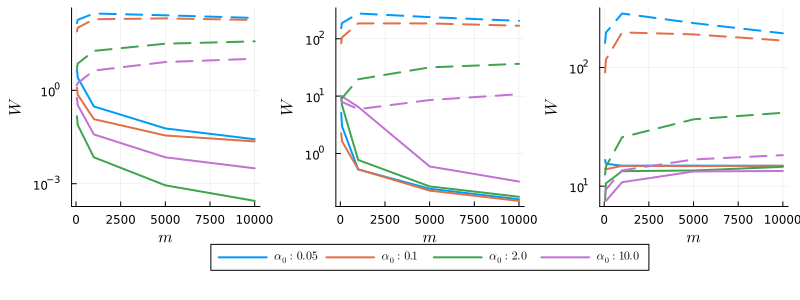

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [109]:
using Plots

TO_PLOT = "LENGTH"

if TO_PLOT == "L1"
    label = L"TV"
elseif TO_PLOT == "LENGTH"
    label = L"W"
elseif TO_PLOT == "POST_N"
    label = L"E(N\mid Z_{1:m})"
elseif TO_PLOT == "MODE_N"
    label = L"mode(N\mid Z_{1:m})"
end

cols_by_a = Dict(0.05 => 1, 0.1 => 2, 2.0 => 3, 10.0 => 4)
main_plots = []

# Save info from dg == 2 for a separate clean legend plot
legend_data = []

for dg in 1:3
    p = plot(yscale = TO_PLOT == "POST_N" ? :identity : :log, legend=false)

    curr_df = mean_df[mean_df.DataGen .== dg, :]
    for prior in PRIORS
        model, a0 = prior
        subdf = curr_df[(curr_df.Model .== model) .& (curr_df.alpha0 .== a0), :]

        if model == "PT" && (TO_PLOT == "POST_N" || TO_PLOT == "MODE_N")
            continue
        end

        linecolor = cols_by_a[a0]
        linestyle = (model == "PT") ? :dash : :solid
        plot!(p, NDATAS, subdf[!, TO_PLOT],
              linewidth=2.0,
              color=linecolor,
              linestyle=linestyle,
              label=false,
              xlabel=L"m", ylabel=label)

        # Store series info if it's the third plot and not PT-skipped
        if dg == 3 && !(model == "PT" && (TO_PLOT in ["POST_N", "MODE_N"]))
            push!(legend_data, (
                x = NDATAS,
                y = subdf[!, TO_PLOT],
                label = (model == "PT") ? "" : L"\alpha_0: %$a0", 
                color = linecolor,
                linestyle = linestyle
            ))
        end
    end
    push!(main_plots, p)
end

legend_plot = plot(
    legend = :outerbottom,
    legendcolumns = 4,
    framestyle = :none,
    grid = false,
    ticks = nothing,
    xlabel = "",
    ylabel = "",
    bottom_margin = -5mm,
    top_margin = 10mm,
    left_margin = 0mm,
    right_margin = 0mm,
    xticks = false,
    yticks = false
)

# Add each series individually and preserve LaTeX labels and styling
for item in legend_data
    if item.linestyle == :solid
        plot!(
            legend_plot,
            [NaN], [NaN],
            label = item.label,
            color = item.color,
            linestyle = item.linestyle,
            linewidth = 2.0
        )
    end
end


# Custom layout: 3 plots top, 1 legend bar below
grid = @layout [a b c; d{0.001h}]
plot(main_plots[1], main_plots[2], main_plots[3], legend_plot;
     layout=grid, size=(800, 300), top_margin=0mm, bottom_margin=6mm, left_margin=4mm)

# savefig("../latex/images/simulation1_$TO_PLOT.pdf")


In [163]:
plots = []

cols_by_a = Dict(0.05 => 1, 2.0 => 2, 10.0 => 3)

for dg in 1:3
    p = plot()
    curr_df = df[df.DataGen .== dg, :]
    for (i, prior) in enumerate(PRIORS)
        model, alpha0 = prior
        subdf = curr_df[(curr_df.Model .== prior[1]) .& (curr_df.alpha0 .== prior[2]), :]

        if model == "PT"
            continue
        else
            plot!(NDATAS, subdf.POST_N, linewidth=2.0, color=cols_by_a[alpha0], label="$alpha0", 
                  xlabel=L"n", ylabel=L"p(n)")
        end
    end
    plots = push!(plots, p)
end

plot((p for p in plots)..., layout=(1, 3), size=(800, 250), left_margin = 5mm, bottom_margin=5mm)

# Example 2) GFPT2 vs GFPT1

In [19]:
DG1 = Uniform(0, 0.5)
DG2 = MixtureModel([
    Uniform(0, 0.25),
    Uniform(0.125, 0.25),
    Uniform(0.5, 1.0)], [1/6, 1/2, 1/3])
DG3 = truncated(Normal(0.5, 0.1), 0.0, 1.0)
DG4 = Uniform(0, 0.2)
DG5 = MixtureModel([
    Uniform(0, 0.2),
    Uniform(0.7, 0.9)], [2/3, 1/3])
DG6 = MixtureModel([
    Beta(2, 15),
    Beta(15, 2)], [1/2, 1/2])
DG = [DG1, DG2, DG3, DG4, DG5, DG6];

In [16]:
XGRID = collect(LinRange(1e-8, 1-1e-8, 1000))
MAX_DEPTH = 8

function get_posterior_summaries(pt::GFPT2, data)
    mcmc_chain = run_mcmc(data, pt, 10000, 5000, 5);
    pred_dens = predictive_density(XGRID, mcmc_chain)
    post_n_proba = zeros(MAX_DEPTH)
    for tree in mcmc_chain
        post_n_proba[tree.curr_n] += 1
    end
    post_n_proba ./= length(mcmc_chain)
    return post_n_proba, pred_dens
end


function get_posterior_summaries(pt::GFPT1, data)
    model = update(data, pt)
    pred_dens = predictive_density(XGRID, model)
    return model.prob_n, pred_dens
end


get_posterior_summaries (generic function with 2 methods)

In [17]:
preds_1 = []
preds_2 = []
post_n_1 = []
post_n_2 = []


for (i, datagen) in enumerate(DG)
    println("i: ", i)
    flush(stdout)
    data = rand(datagen, 500);
    pt = GFPT2(Poisson(3.0), 8, 0.1, 2.0);
    gfpt1 = GFPT1(Poisson(3.0), 8, 0.1);

    post_n, pred = get_posterior_summaries(pt, data)
    preds_2 = push!(preds_2, pred)
    post_n_2 = push!(post_n_2, post_n)

    post_n, pred = get_posterior_summaries(gfpt1, data)
    preds_1 = push!(preds_1, pred)
    post_n_1 = push!(post_n_1, post_n)
end

i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7


In [68]:
plots = []
for (i, datagen) in enumerate(DG)
    p = plot()
    true_dens = pdf.(datagen, XGRID)
    plot!(XGRID, true_dens, color="black", label="True", linewidth=2.0, title="DG"*string(i))
    plot!(XGRID, preds_1[i], color=1, label="GFPT1", linewidth=2.0)
    plot!(XGRID, preds_2[i], color=2, label="GFPT2", linewidth=2.0)
    plots = push!(plots, p)
end
    

In [69]:
plot((p for p in plots[1:3])..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=3)
savefig(savefig("../latex/images/gfpt_12_ex1_dens.pdf"))


"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex1_dens.pdf"

In [70]:
plot((p for p in plots[4:end])..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=3)
savefig(savefig("../latex/images/gfpt_12_ex2_dens.pdf"))


"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex2_dens.pdf"

In [60]:
using StatsPlots

plots = []
for (i, datagen) in enumerate(DG)
    p = plot()
    bars = [post_n_1[i]; post_n_2[i]]
    labels = repeat(["GFPT1", "GFPT2"], inner = 8)
    groupedbar!(repeat(collect(1:8), outer=2), bars, group=labels, xticks=collect(1:8), 
                title="DG"*string(i), ylabel=L"P(N=n \,|\, Z)", xlabel=L"n", ylim=(0.0, 1.0))
    plots = push!(plots, p)
end

In [66]:
plot((p for p in plots[1:3])..., layout=(1, 3), size=(810, 350))
plot!(legend=:outerbottom, legendcolumns=2, left_margin = 5mm, bottom_margin=5mm)
savefig(savefig("../latex/images/gfpt_12_ex1_post_n.pdf"))

"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex1_post_n.pdf"

In [67]:
plot((p for p in plots[4:end])..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=2, left_margin = 5mm, bottom_margin=5mm)
savefig(savefig("../latex/images/gfpt_12_ex2_post_n.pdf"))


"/Users/marioberaha/Documents/papers/polyatree/latex/images/gfpt_12_ex2_post_n.pdf"

# Quantitative metrics

In [3]:
using Distributions
using Plots
using Serialization
using DataFrames
using LaTeXStrings
using Plots.PlotMeasures


df = Serialization.deserialize("simulation2_results.dta")

mean_df = combine(DataFrames.groupby(df, [:Model, :alpha0, :beta0, :increasing_beta, :DataGen, :Ndata]), 
                  :L1 => mean => :L1, :LENGTH => mean => :LENGTH,
                  :POST_N => mean => :POST_N);

In [8]:
using DataFrames, StatsPlots


TO_PLOT = "L1"

if TO_PLOT == "L1"
    label=L"TV"
elseif TO_PLOT == "LENGTH"
    label=L"W"
elseif TO_PLOT == "POST_N"
    label=L"E(N \mid Z_{1:m})"
end

# Assume your DataFrame is named `df`
# Create a grouping string for the (Model, α0, β0) combination
df.Group = string.(df.Model, ", α=", df.alpha0, ", β=", df.beta0)

# Array to store individual plots for each DataGen
plots = []
legend_data = []

# Loop through DataGen values 1 through 6
for d in 1:6
    # Filter the DataFrame for the current DataGen
    df_sub = filter(row -> row.DataGen == d, df)
    
    # Create a blank plot for the current DataGen with axis labels and title
    p = plot(title = "DG$d", xlabel = "Group (Model, α0, β0)", ylabel = "L1", legend = :topleft)

    labels= ["GFPT1", "β0: 0.5", "β0: 2.0", "β0: 5.0", 
             "β0: 0.5", "β0: 2.0", "β0: 5.0"]
    
    # For each unique Model in the filtered data, customize the boxplot
    for model in unique(df_sub.Model)
        # Filter for the current model
        df_model = filter(row -> row.Model == model, df_sub)


        for alpha0 in [0.1, 2.0]

            df_alpha = filter(row -> row.alpha0 == alpha0, df_model)

            if size(df_alpha)[1] == 0
                continue
            end
       
            custom_color = alpha0 > 0.5 ? :1 : :2
            if model == "GFPT1"
                custom_color = 3
            end
            
            # Add the boxplot for this model with customized style
            boxplot!(df_alpha.Group, df_alpha[:, TO_PLOT],
                color = custom_color, xrotation=45,
                label = "", xlabel="", ylabel=label, top_margin=0mm, bottom_margin=5mm)

            if d == 1
                push!(legend_data, (
                    x = df_alpha.Group,
                    y = df_alpha[!, TO_PLOT],
                    label = "($(model), α0: $(alpha0))", 
                    color=custom_color
                ))
            end
        end


    end
    
    # Rotate the x-axis labels if needed (this rotates the labels for the entire subplot)
    plot!(p, xtickfont = font(8, rotation = 90))
    plot!(xticks=([0.5, 1.9, 2.9, 3.9, 5.3, 6.3, 7.3, 8.3], labels))
    
    # Save the subplot in the array
    push!(plots, p)
end

# Combine the six plots into a 2 x 3 grid and set overall size
# p_grid = plot(plots..., layout = (2, 3), size = (1000, 500), left_margin=5mm)
# display(p_grid)


legend_plot = plot(
    legend = :outerbottom,
    legendcolumns = 4,
    framestyle = :none,
    grid = false,
    ticks = nothing,
    xlabel = "",
    ylabel = "",
    bottom_margin = -5mm,
    top_margin = 10mm,
    left_margin = 0mm,
    right_margin = 0mm,
    xticks = false,
    yticks = false
)

# Add each series individually and preserve LaTeX labels and styling
for item in legend_data
    plot!(
        legend_plot,
        [NaN], [NaN],
        seriestype=:path,
        label = item.label,
        color = item.color,
        linewidth = 8.0
    )
end


# # Custom layout: 3 plots top, 1 legend bar below
gr = @layout [a b c; d e f; g{0.001h}] 
plot(plots..., legend_plot;
     layout=gr, size=(800, 400), top_margin=0mm, bottom_margin=6mm, left_margin=4mm)
savefig("../latex/images/simulation2_$TO_PLOT.pdf")

┌ Warning: n° of legend_column=4 is larger than n° of series=3
└ @ Plots /Users/marioberaha/.julia/packages/Plots/Ec1L1/src/backends/gr.jl:1235
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/Users/marioberaha/Documents/uni/papers/polyatree/latex/images/simulation2_L1.pdf"